In [3]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'CS6140-Project/data/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [4]:
!pip install rouge
!pip install nltk
!pip install gcsfs
!pip install torch torchvision torchaudio
!pip install transformers

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import string
import networkx as nx
import re
from rouge import Rouge
from itertools import product

In [6]:
train_df = pd.read_csv('/content/drive/My Drive/' + FOLDERNAME + 'samsum-train.csv')
test_df = pd.read_csv('/content/drive/My Drive/' + FOLDERNAME + 'samsum-test.csv')
validation_df = pd.read_csv('/content/drive/My Drive/' + FOLDERNAME + 'samsum-validation.csv')

In [7]:
train_df.head()

,id,dialogue,summary
0,13818513,Amanda: I baked cookies. Do you want some?\r\...,Amanda baked cookies and will bring Jerry some...
1,13728867,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...
2,13681000,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa...",Kim may try the pomodoro technique recommended...
3,13730747,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...
4,13728094,Sam: hey overheard rick say something\r\nSam:...,"Sam is confused, because he overheard Rick com..."


In [8]:
validation_df.head()

,id,dialogue,summary
0,13817023,"A: Hi Tom, are you busy tomorrow’s afternoon?\...",A will go to the animal shelter tomorrow to ge...
1,13716628,Emma: I’ve just fallen in love with this adven...,Emma and Rob love the advent calendar. Lauren ...
2,13829420,Jackie: Madison is pregnant\r\nJackie: but she...,Madison is pregnant but she doesn't want to ta...
3,13819648,Marla: <file_photo>\r\nMarla: look what I foun...,Marla found a pair of boxers under her bed.
4,13728448,Robert: Hey give me the address of this music ...,Robert wants Fred to send him the address of t...


In [9]:
test_df.head()

,id,dialogue,summary
0,13862856,"Hannah: Hey, do you have Betty's number?\nAman...",Hannah needs Betty's number but Amanda doesn't...
1,13729565,Eric: MACHINE!\r\nRob: That's so gr8!\r\nEric:...,Eric and Rob are going to watch a stand-up on ...
2,13680171,"Lenny: Babe, can you help me with something?\r...",Lenny can't decide which trousers to buy. Bob ...
3,13729438,"Will: hey babe, what do you want for dinner to...",Emma will be home soon and she will let Will k...
4,13828600,"Ollie: Hi , are you in Warsaw\r\nJane: yes, ju...",Jane is in Warsaw. Ollie and Jane has a party....


In [10]:
#Check the shape of the dataset
def print_shape_df(df, ds_name="df"):

    print(f"{ds_name} dataset has {df.shape[0]} rows and {df.shape[1]} columns")

print_shape_df(train_df, "training")
print_shape_df(test_df, "testing")
print_shape_df(validation_df, "validation")

training dataset has 14732 rows and 3 columns
testing dataset has 819 rows and 3 columns
validation dataset has 818 rows and 3 columns


In [11]:
#Check the null values
def check_null(df, ds_name='df'):
    print(f"Null Values in each col in the {ds_name} dataset:\n")
    print(df.isnull().sum())

check_null(train_df, "training")
print()
check_null(test_df, "testing")
print()
check_null(validation_df, "validation")

Null Values in each col in the training dataset:

id          0
dialogue    1
summary     0
dtype: int64

Null Values in each col in the testing dataset:

id          0
dialogue    0
summary     0
dtype: int64

Null Values in each col in the validation dataset:

id          0
dialogue    0
summary     0
dtype: int64


## Data preprocessing

In [12]:
# Drop rows with any null values in the training dataset
train_df = train_df.dropna()

# Recheck for null values after dropping
check_null(train_df, "training")

Null Values in each col in the training dataset:

id          0
dialogue    0
summary     0
dtype: int64


In [13]:
#remove tages
def clean_tags(text):
    clean = re.compile('<.*?>') # Compiling tags
    clean = re.sub(clean, '', text) # Replacing tags text by an empty string

    # Removing empty dialogues
    clean = '\n'.join([line for line in clean.split('\n') if not re.match('.*:\s*$', line)])

    return clean

In [59]:
def remove_emojis(text):
    # Define the pattern for matching emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    # Remove emojis from the text
    return emoji_pattern.sub(r'', text)

In [60]:
# Defining function to clean every text in the dataset.
def clean_df(df, cols):
    for col in cols:
        df[col] = df[col].fillna('').apply(clean_tags)
        df[col] = df[col].apply(remove_emojis)
    return df

In [61]:
# Cleaning texts in all datasets
train_df = clean_df(train_df,['dialogue', 'summary'])
test_df = clean_df(test_df,['dialogue', 'summary'])
validation_df = clean_df(validation_df,['dialogue', 'summary'])

In [62]:
train_df.tail(3)

,id,dialogue,summary,TF-IDF Generated Summary,TextRank Summary,Best TF-IDF Summary
14729,13819050,John: Every day some bad news. Japan will hunt...,Japan is going to hunt whales again. Island an...,scandinavians n't use nets japanese use norway...,scandinavians n't use nets japanese use norway...,scandinavians n't use nets japanese use norway...
14730,13828395,Jennifer: Dear Celia! How are you doing?\r\nJe...,Celia couldn't make it to the afternoon with t...,jennifer maria brought plenty cookies still li...,jennifer dear celia celia thank dear celia my ...,jennifer maria brought plenty cookies i still ...
14731,13729017,Georgia: are you ready for hotel hunting? We n...,Georgia and Juliette are looking for a hotel i...,need book something finally lisbon juliette su...,georgia ok give second juliette sure georgia a...,we need book something finally lisbon juliette...


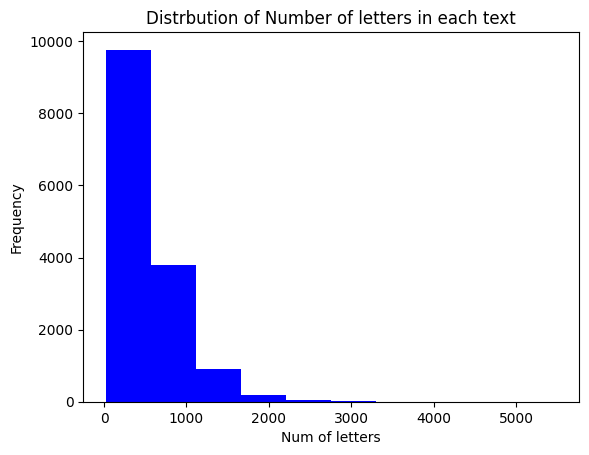

In [63]:
letters_len=train_df['dialogue'].str.len()
plt.hist(letters_len,color='blue')
plt.title("Distrbution of Number of letters in each text")
plt.xlabel("Num of letters")
plt.ylabel("Frequency")
plt.show()

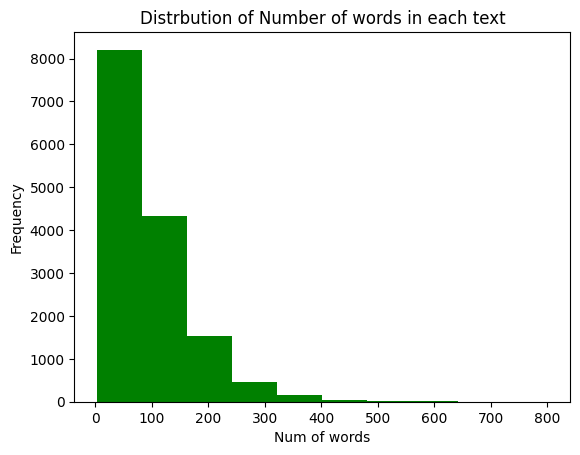

In [64]:
words_len=train_df['dialogue'].str.split().map(lambda x: len(x))
plt.hist(words_len,color='green')
plt.title("Distrbution of Number of words in each text")
plt.xlabel("Num of words")
plt.ylabel("Frequency")
plt.show()

<ipython-input-65-96ff532b645b>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word,color='red')


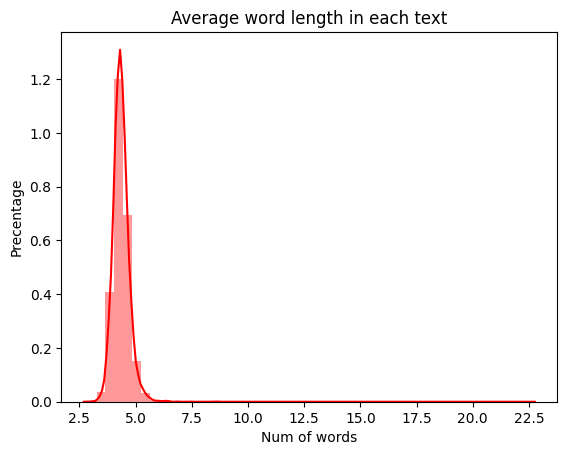

In [65]:
word=train_df['dialogue'].str.split().apply(lambda x : [len(i) for i in x])
word = word.map(lambda x: np.mean(x))
sns.distplot(word,color='red')
plt.title("Average word length in each text")
plt.xlabel("Num of words")
plt.ylabel("Precentage")
plt.show()

## TF-IDF

In [66]:
nltk.download('punkt')
nltk.download('stopwords')

def preprocess(text):
    text = text.lower()  # Lowercasing
    sentences = sent_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_sentences = []
    for sent in sentences:
        words = word_tokenize(sent)
        filtered_words = [word for word in words if word not in stop_words and word not in string.punctuation]
        filtered_sentences.append(' '.join(filtered_words))
    return filtered_sentences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [67]:
def tfidf_vectorize(sentences, max_df=1.0, min_df=1, ngram_range=(1, 2)):
    try:
        vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, ngram_range=ngram_range)
        sentence_vectors = vectorizer.fit_transform(sentences)
        return sentence_vectors, vectorizer, True  # True indicates success
    except ValueError:
        return None, None, False  # False indicates failure

In [68]:
def tfidf_summarize(dialogue, num_sentences=3, max_df=1.0, min_df=1, ngram_range=(1, 2)):
    sentences = preprocess(dialogue)
    sentence_vectors, vectorizer, success = tfidf_vectorize(sentences, max_df=max_df, min_df=min_df, ngram_range=ngram_range)
    if success and sentence_vectors is not None:
        scores = np.array(sentence_vectors.sum(axis=1)).ravel()
        ranked_sentences = [sentences[i] for i in np.argsort(scores, axis=0)[::-1]]
        return ' '.join(ranked_sentences[:num_sentences])
    else:
        return None  # Return None if vectorization failed

In [69]:
# Generate summaries for all dialogues
generated_summaries = train_df['dialogue'].apply(tfidf_summarize)

# Add these summaries to original DataFrame
train_df['TF-IDF Generated Summary'] = generated_summaries

# Randomly select 5 dialogues for comparison
random_comparison = train_df.sample(5, random_state=np.random.RandomState())

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual Summary': random_comparison['summary'],
    'TF-IDF Generated Summary': random_comparison['TF-IDF Generated Summary']
})

# Use Styler for left alignment of the comparison DataFrame
comparison_df_styled = comparison_df.style.set_properties(**{'text-align': 'left'})
comparison_df_styled

,Actual Summary,TF-IDF Generated Summary
590,Jose's bus is running 4 minutes late.,jose far 4 mins natalie ok ben ok let us know 're jose bus running late ben long
5900,Mike's got a new expensive bike.,adam looks great mike new bike much cost
12102,"Helen, Laura and Marcela will meet at the university next week. They graduated 2 years ago.",marcela believe 's two years since finished university laura time flies marcela shall meet uni laura uni would nice laura could see anything changed helen drink cafeteria p helen 'm excited see next week laura
3881,Julian works as a security guard on nights and weekend and is going to Manchester tonight. Julian will sleep in the weekend. Emma will study. Emma's dad's birthday is tomorrow and she will make a banana fudge cake for the occasion.,emma thinking banana fudge cake ... mainly cos sounds tasty p julian ooh spunds amazing emma lets hope tastes amazing julian bet emma 'll let know julian okay save slice plans comparison kinda boring p tying loose ends break julian yeah amazing im gon na breaking heads left right center emma someone 's fun p elle lucy btw emma sound boring ... studying 's dad bday tomorrow 'll probably take brrak emma im making cake julian aah okay oooh cake gon na make
2482,The 4th season of Narcos is out today. Ola and Thomas have seen the previous season. The new season is taking place in Mexico and features an actor that Thomas can't imagine in a serious role. It doesn't seem interesting to Thomas.,thomas idea p ola 4th even seen previous one thomas two ola ok ok. know new season happening plus ca n't imagine actor playing serious role


In [24]:
print("Length of generated summaries:", len(generated_summaries))
print("Length of reference summaries:", len(train_df['summary']))

Length of generated summaries: 14731
Length of reference summaries: 14731


In [25]:
def calculate_rouge_scores(generated_summaries, reference_summaries):
    rouge = Rouge()
    scores = rouge.get_scores(generated_summaries, reference_summaries, avg=True)
    return scores

# Re-generate summaries
generated_summaries = [tfidf_summarize(dialogue) for dialogue in train_df['dialogue']]

# Convert all elements to strings in generated_summaries
generated_summaries = [str(summary) for summary in generated_summaries]

train_df['summary'] = train_df['summary'].astype(str)

# Re-calculate ROUGE scores
rouge_scores = calculate_rouge_scores(generated_summaries, train_df['summary'].tolist())
rouge_scores_df = pd.DataFrame.from_dict(rouge_scores, orient='index')
rouge_scores_df.columns = ['F1-Score', 'Precision', 'Recall']
print(rouge_scores_df)

         F1-Score  Precision    Recall
rouge-1  0.194327   0.151060  0.161869
rouge-2  0.030506   0.020628  0.023024
rouge-l  0.175202   0.136214  0.145849


 F1-Score  Precision    Recall
rouge-1  0.194327   0.151060  0.161869
rouge-2  0.030506   0.020628  0.023024
rouge-l  0.175202   0.136214  0.145849

## TF-IDF Parameter Tuning

In [28]:
# param_grid = {
#     'max_df': [0.9, 0.95],
#     'min_df': [0.001, 0.01],
#     'ngram_range': [(1, 1), (1, 2), (1, 3)],
#     'num_sentences': [1, 2, 3]
# }

# rouge_evaluator = Rouge()
# best_score = 0
# best_params = None

# for combo in product(*param_grid.values()):
#     params = dict(zip(param_grid.keys(), combo))

#     generated_summaries = [tfidf_summarize(dialogue, **params) for dialogue in train_df['dialogue']]
#     generated_summaries = [summary if summary is not None else "" for summary in generated_summaries]  # Replace None with empty strings

#     try:
#         scores = rouge_evaluator.get_scores(generated_summaries, train_df['summary'].tolist(), avg=True)
#         avg_rouge_score = np.mean([scores['rouge-1']['f'], scores['rouge-2']['f'], scores['rouge-l']['f']])
#         if avg_rouge_score > best_score:
#             best_score = avg_rouge_score
#             best_params = params
#     except ValueError:
#         # Skip this combination if ROUGE calculation fails
#         continue

# print(f"Best Params: {best_params}, Best ROUGE Score: {best_score}")

In [43]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from random import sample

param_grid = {
    'max_df': uniform(0.8, 1.0),  # Range from 0.8 to 1.0
    'min_df': uniform(0.001, 0.01),  # Range from 0.001 to 0.021
    'ngram_range': [(1, 1), (1, 2), (1, 3)],
    'num_sentences': [1, 2, 3, 4]
}


# Randomly sample combinations from the parameter space
num_combinations = 50  # Number of random combinations to sample
random_combinations = sample(list(product(param_grid['max_df'].rvs(size=100),
                                          param_grid['min_df'].rvs(size=100),
                                          param_grid['ngram_range'],
                                          param_grid['num_sentences'])),
                             num_combinations)

In [44]:
rouge_evaluator = Rouge()
best_score = 0
best_params = None

for params in random_combinations:
    max_df, min_df, ngram_range, num_sentences = params
    generated_summaries = [tfidf_summarize(dialogue, num_sentences, max_df, min_df, ngram_range) for dialogue in train_df['dialogue'][:5]]  # Test on a subset
    generated_summaries = [summary if summary is not None else "" for summary in generated_summaries]

    try:
        scores = rouge_evaluator.get_scores(generated_summaries, train_df['summary'].tolist()[:5], avg=True)
        rouge_1_score = scores['rouge-1']['f']
        rouge_2_score = scores['rouge-2']['f']
        rouge_l_score = scores['rouge-l']['f']

        avg_rouge_score = np.mean([rouge_1_score, rouge_2_score, rouge_l_score])
        if avg_rouge_score > best_score:
            best_score = avg_rouge_score
            best_params = params
            # Store the individual ROUGE scores for the best parameter set
            best_scores = {'rouge-1': rouge_1_score, 'rouge-2': rouge_2_score, 'rouge-l': rouge_l_score}
    except ValueError:
        continue

print(f"Best Params: {best_params}, Best Avg ROUGE Score: {best_score}")
print(f"Best ROUGE-1 Score: {best_scores['rouge-1']}, Best ROUGE-2 Score: {best_scores['rouge-2']}, Best ROUGE-L Score: {best_scores['rouge-l']}")



Best Params: (0.8860642772248835, 0.006287404238110133, (1, 1), 2), Best Avg ROUGE Score: 0.1474751811050006
Best ROUGE-1 Score: 0.24250128785590822, Best ROUGE-2 Score: 0.03428571270122459, Best ROUGE-L Score: 0.165638542757869


Best Params: (0.8860642772248835, 0.006287404238110133, (1, 1), 2), Best Avg ROUGE Score: 0.1474751811050006
Best ROUGE-1 Score: 0.24250128785590822, Best ROUGE-2 Score: 0.03428571270122459, Best ROUGE-L Score: 0.165638542757869

In [51]:
# Best parameters identified from your analysis
best_tfidf_params = {
    'max_df': 0.886,
    'min_df': 0.006,
    'ngram_range': (1, 1),
    'num_sentences': 2
}

# Apply the TF-IDF summarization with the best parameters to each dialogue in your DataFrame
train_df['Best TF-IDF Summary'] = train_df['dialogue'].apply(lambda x: tfidf_summarize(x, **best_tfidf_params))

# Display some example summaries for inspection
print(train_df[['dialogue', 'Best TF-IDF Summary']].head())

                                            dialogue  \
0  Amanda: I baked  cookies. Do you want some?\r\...   
1  Olivia: Who are you voting for in this electio...   
2  Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa...   
3  Edward: Rachel, I think I'm in ove with Bella....   
4  Sam: hey  overheard rick say something\r\nSam:...   

                                 Best TF-IDF Summary  
0  amanda i 'll bring tomorrow amanda i baked coo...  
1  olivia who voting election oliver liberals always  
2  kim oh know uni stuff unfucking room kim maybe...  
3  edward rachel i think i 'm ove bella .. rachel...  
4  naomi honestly 's bothering much talk naomi se...  


In [58]:
# Create a DataFrame for comparison
tuned_comparison_df = pd.DataFrame({
    'Actual Summary': train_df['summary'],
    'Best TF-IDF Summary': train_df['Best TF-IDF Summary']
})

tuned_comparison_subset = tuned_comparison_df.head(5)
# Use Styler for left alignment of the comparison DataFrame
tuned_comparison_df_styled = tuned_comparison_subset.style.set_properties(**{'text-align': 'left'})

# Display the styled DataFrame
tuned_comparison_df_styled

,Actual Summary,Best TF-IDF Summary
0,Amanda baked cookies and will bring Jerry some tomorrow.,amanda i 'll bring tomorrow amanda i baked cookies
1,Olivia and Olivier are voting for liberals in this election.,olivia who voting election oliver liberals always
2,Kim may try the pomodoro technique recommended by Tim to get more stuff done.,kim oh know uni stuff unfucking room kim maybe tomorrow i 'll move ass everything kim we going defrost fridge instead shopping i 'll eat defrosted veggies tim for stuff i recommend pomodoro technique u use breaks chores tim it really helps kim thanks maybe i 'll tim i also like using post-its kaban style kim bad mood tbh i going lots stuff ended procrastinating tim what plan
3,Edward thinks he is in love with Bella. Rachel wants Edward to open his door. Rachel is outside.,edward rachel i think i 'm ove bella .. rachel dont say anything else .. edward what mean rachel open fu ing door ..
4,"Sam is confused, because he overheard Rick complaining about him as a roommate. Naomi thinks Sam should talk to Rick. Sam is not sure what to do.",naomi honestly 's bothering much talk naomi see 's going sam n't want get kind confrontation though sam maybe 'll let go sam see goes future naomi 's choice sam naomi would talk clear air sam thought good rommate sam nice place naomi 's true man


## TextRank

In [45]:
def preprocess(text):
    stop_words = set(stopwords.words('english'))
    sentences = sent_tokenize(text)
    processed_sentences = []
    for sentence in sentences:
        words = word_tokenize(sentence)
        filtered_words = [word.lower() for word in words if word not in stop_words and word not in string.punctuation]
        processed_sentences.append(' '.join(filtered_words))
    return processed_sentences

In [46]:
def build_similarity_matrix(sentences):
    vectorizer = TfidfVectorizer()
    sentence_vectors = vectorizer.fit_transform(sentences)
    similarity_matrix = cosine_similarity(sentence_vectors)
    return similarity_matrix

In [47]:
def textrank_summarize(text, top_n=3):
    sentences = preprocess(text)
    similarity_matrix = build_similarity_matrix(sentences)

    nx_graph = nx.from_numpy_array(similarity_matrix)
    scores = nx.pagerank(nx_graph)

    ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
    selected_sentences = [sentences[i] for i, _ in sorted(enumerate(sentences), key=lambda x: scores[x[0]], reverse=True)[:top_n]]
    return ' '.join(selected_sentences)

In [48]:
# Preprocess and generate summaries
train_df['TextRank Summary'] = train_df['dialogue'].apply(textrank_summarize)

# Randomly select 5 dialogues for comparison
TR_comparison_samples = train_df.sample(5, random_state=np.random.RandomState())

# Create a DataFrame for comparison
TR_comparison_df = pd.DataFrame({
    'Actual Summary': TR_comparison_samples['summary'],
    'TextRank Summary': TR_comparison_samples['TextRank Summary']
})

# Use Styler for left alignment of the comparison DataFrame
TR_comparison_df_styled = TR_comparison_df.style.set_properties(**{'text-align': 'left'})
TR_comparison_df_styled

,Actual Summary,TextRank Summary
3507,"Chloe finds the new math teacher attractive and reasonable, Andrew hasn't met him yet.",andrew let see chloe hot right andrew i bet chloe are coming tomorrow andrew yep chloe you chance meet person
4713,Amber and Hugh didn't invite Lilly to go with them to a concert tonight. Heather invites her to go to the cinema with her and her high school friends instead.,heather bunch friends high school going lilly thanks invite lilly 'd love feel insulted lilly amber hugh going concert tonight lilly n't invite
8036,Sarah hit the pillar with the car while she was leaving her parking spot.,jack d zoe kidding xd jack amazing ... sarah thanks guys ... zoe manage ripped whole thing lol jack somebody needs learn drive lol sarah leaving parking spot ... sarah touched pillar ... jack d jack sorry 's really funny zoe jack ... zoe 's gon na ok ... xd sarah really thanks ... n't told anything jack haha good job
3735,Rowan is joining Jo for lunch tommorow at 1 pm at the Pret next to the BL.,jo see tomorrow rowan cool jo i 'd say 1 pm 's ok rowan yeah sure jo see rowan sure
1815,"Jorge, Sierra and Taylor are taking the astronomy class together.",sierra you rn sierra theres many classes open spots left jorge oh noo jorge i ca n't believe people jorge are choosing time sierra i n't know take sierra honestly taylor were screwed 😵 taylor i take look rn jorge are taking science together


In [49]:
# Calculate ROUGE scores for generated summaries
rouge_evaluator = Rouge()
TR_rouge_scores = rouge_evaluator.get_scores(train_df['TextRank Summary'].tolist(), train_df['summary'].tolist(), avg=True)
TR_rouge_scores_df = pd.DataFrame.from_dict(rouge_scores, orient='index')
TR_rouge_scores_df.columns = ['F-Score', 'Precision', 'Recall']

In [50]:
print(TR_rouge_scores_df)

          F-Score  Precision    Recall
rouge-1  0.194327   0.151060  0.161869
rouge-2  0.030506   0.020628  0.023024
rouge-l  0.175202   0.136214  0.145849


F-Score  Precision    Recall
rouge-1  0.194327   0.151060  0.161869
rouge-2  0.030506   0.020628  0.023024
rouge-l  0.175202   0.136214  0.145849

## TextRank Parameter tuning

In [70]:
from random import randint

# Define the range for the 'top_n' parameter
top_n_range = range(1, 6)  # Varying it from 1 to 5

# Define number of random trials
num_trials = 20

best_score = 0
best_top_n = None
best_individual_scores = None
rouge_evaluator = Rouge()

for _ in range(num_trials):
    # Randomly select a 'top_n' value
    top_n = randint(min(top_n_range), max(top_n_range))

    # Generate summaries using TextRank
    train_df['TextRank Summary'] = train_df['dialogue'].apply(lambda x: textrank_summarize(x, top_n=top_n))

    # Calculate ROUGE scores
    scores = rouge_evaluator.get_scores(train_df['TextRank Summary'].tolist(), train_df['summary'].tolist(), avg=True)
    avg_rouge_score = np.mean([scores['rouge-1']['f'], scores['rouge-2']['f'], scores['rouge-l']['f']])

    # Update the best score and parameters
    if avg_rouge_score > best_score:
        best_score = avg_rouge_score
        best_top_n = top_n
        best_individual_scores = scores  # Store individual ROUGE scores

print(f"Best top_n: {best_top_n}, Best Avg ROUGE Score: {best_score}")
print(f"Best ROUGE-1 Score: {best_individual_scores['rouge-1']['f']}, Best ROUGE-2 Score: {best_individual_scores['rouge-2']['f']}, Best ROUGE-L Score: {best_individual_scores['rouge-l']['f']}")

Best top_n: 5, Best Avg ROUGE Score: 0.1039687931186221
Best ROUGE-1 Score: 0.1533453458574562, Best ROUGE-2 Score: 0.020235327304501366, Best ROUGE-L Score: 0.13832570619390872


Best top_n: 5, Best Avg ROUGE Score: 0.1039687931186221
Best ROUGE-1 Score: 0.1533453458574562, Best ROUGE-2 Score: 0.020235327304501366, Best ROUGE-L Score: 0.13832570619390872

In [71]:
best_textrank_top_n = 5

# Apply TextRank summarization with the best parameters to each dialogue in the DataFrame
train_df['Best TextRank Summary'] = train_df['dialogue'].apply(lambda x: textrank_summarize(x, best_textrank_top_n))

In [72]:
tuned_TR_comparison_samples = train_df.sample(5, random_state=42)

# Create a DataFrame for comparison between actual summaries and best TextRank summaries
tuned_TR_comparison_df = pd.DataFrame({
    'Actual Summary': tuned_TR_comparison_samples['summary'],
    'Best TextRank Summary': tuned_TR_comparison_samples['Best TextRank Summary']
})

# Use Styler for left alignment of the comparison DataFrame
tuned_TR_comparison_df_styled = tuned_TR_comparison_df.style.set_properties(**{'text-align': 'left'})

# Display the styled DataFrame
tuned_TR_comparison_df_styled

,Actual Summary,Best TextRank Summary
4742,Violet sent Claire Austin's article.,claire thanks thinking came across austin 's article thought might find interesting claire hi thanks 've already read violet hi
8871,"Mel bought Christmas presents while Evie keeps putting it off to the last minute. They have to buy a lot of gifts for their families. Mel is busy with her teaching job too. Evie misses it. Mel's and Evie were invited to Christmas lunches, so they do not have to cook.",mel well yeah mel well done mel mel lot want christmas mel well 've got inspection school last week term
6555,"Fiona can't talk to Carol, because she's very busy. She promised to contact him tomorrow.",carol talk carol pls try make effort really need talk fiona promise 'll try carol avail carol speak
12900,Tom has a map of Paris.,adam u map paris tom yes trip adam 's lisa mum
2596,"Mike is happy, because Sam's moved out. Mike and Frank grumble about Brexit. Frank is in dispute with Freda, because she voted for Brexit. Mike will talk to Freda in order to help Frank.",frank yes 'd appreciate mike mike oh vague memories frank long ago frank yeah 'd never thought years ago would happened mike shall try talk freda come friday mike bloody brexit


In [73]:
train_df.to_csv('train_df.csv', index=False)

In [74]:
from google.colab import files
files.download('train_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Evaluate

In [1]:
# Apply TF-IDF summarization to the validation dataset
validation_df['TF-IDF Summary'] = validation_df['dialogue'].apply(lambda x: tfidf_summarize(x, **best_tfidf_params))

# Apply TextRank summarization to the validation dataset
validation_df['TextRank Summary'] = validation_df['dialogue'].apply(lambda x: textrank_summarize(x, best_textrank_top_n))


NameError: ignored

In [ ]:
# Calculate ROUGE scores for TF-IDF on validation dataset
tfidf_rouge_scores_validation = rouge_evaluator.get_scores(validation_df['TF-IDF Summary'].tolist(), validation_df['summary'].tolist(), avg=True)

# Calculate ROUGE scores for TextRank on validation dataset
textrank_rouge_scores_validation = rouge_evaluator.get_scores(validation_df['TextRank Summary'].tolist(), validation_df['summary'].tolist(), avg=True)


In [ ]:
# The test dataset
tfidf_rouge_scores_test = rouge_evaluator.get_scores(test_df['TF-IDF Summary'].tolist(), test_df['summary'].tolist(), avg=True)
textrank_rouge_scores_test = rouge_evaluator.get_scores(test_df['TextRank Summary'].tolist(), test_df['summary'].tolist(), avg=True)

In [ ]:
print("TF-IDF ROUGE scores on Validation:", tfidf_rouge_scores_validation)
print("TextRank ROUGE scores on Validation:", textrank_rouge_scores_validation)
print("TF-IDF ROUGE scores on Test:", tfidf_rouge_scores_test)
print("TextRank ROUGE scores on Test:", textrank_rouge_scores_test)

##Future work: Try transfomer models like Bert

In [75]:
from transformers import BartTokenizer, BartForConditionalGeneration, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
import torch

In [76]:
# Define a dataset class
class SummaryDataset(Dataset):
    def __init__(self, tokenizer, df, max_length=512):
        self.tokenizer = tokenizer
        self.inputs = df['dialogue']
        self.targets = df['summary']
        self.max_length = max_length

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_text = str(self.inputs[idx])
        target_text = str(self.targets[idx])

        # Tokenize inputs and targets
        input_encodings = self.tokenizer(input_text, truncation=True, padding='max_length', max_length=self.max_length)
        target_encodings = self.tokenizer(target_text, truncation=True, padding='max_length', max_length=self.max_length)

        return {
            'input_ids': torch.tensor(input_encodings['input_ids']),
            'attention_mask': torch.tensor(input_encodings['attention_mask']),
            'labels': torch.tensor(target_encodings['input_ids'])
        }

In [78]:
# Load tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

# Create datasets
train_dataset = SummaryDataset(tokenizer, train_df)
validate_dataset = SummaryDataset(tokenizer, validation_df)

# Create DataLoaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size)

In [79]:
# Load model
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

# Move model to GPU
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("GPU")
    device = torch.device('cuda')
else:
    print("CPU")
    device = torch.device('cpu')

model.to(device)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * num_epochs)

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

CPU


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


NameError: ignored

In [81]:
from tqdm.auto import tqdm

In [ ]:
num_epochs = 3  # Number of epochs to train for

for epoch in range(num_epochs):
    # Training
    model.train()
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

    # Validation
    model.eval()
    total_eval_loss = 0
    for batch in tqdm(validate_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            loss = outputs.loss
            total_eval_loss += loss.item()

    avg_val_loss = total_eval_loss / len(validate_loader)
    print(f'Epoch {epoch} Validation Loss: {avg_val_loss}')

  0%|          | 0/3683 [00:00<?, ?it/s]

In [ ]:
def generate_summary(batch, model, tokenizer, device):
    # Move batch to the same device as the model
    inputs = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}

    # Generate summary IDs
    summary_ids = model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'], max_length=150, length_penalty=2.0, num_beams=4, early_stopping=True)

    # Decode and clean up summaries
    summaries = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]
    return summaries

# Generate summaries for the validation set
model.eval()
all_generated_summaries = []
all_actual_summaries = []
for batch in tqdm(validate_loader):
    generated_summaries = generate_summary(batch, model, tokenizer, device)
    actual_summaries = [tokenizer.decode(ids, skip_special_tokens=True) for ids in batch['labels']]
    all_generated_summaries.extend(generated_summaries)
    all_actual_summaries.extend(actual_summaries)

In [ ]:
rouge_evaluator = Rouge()
Bart_rouge_scores = rouge_evaluator.get_scores(all_generated_summaries, all_actual_summaries, avg=True)

# Convert ROUGE scores to a DataFrame for easy viewing
Bart_rouge_scores_df = pd.DataFrame.from_dict(rouge_scores, orient='index')
Bart_rouge_scores_df.columns = ['F-Score', 'Precision', 'Recall']
print(Bart_rouge_scores_df)